In [12]:
import pandas as pd
from patsy import dmatrix

from neural_priors.utils.data import get_all_behavioral_data
import pymc as pm
import numpy as np

from bound_vars.utils.math import softplus_np, inverse_softplus_np
import pytensor.tensor as pt

In [13]:
df = get_all_behavioral_data()

In [14]:
df = df[~df['response'].isnull()]
df['bias'] = df['response'] - df['n']


In [15]:
dof_splines = 6
data = df


sub_ix, subject_mapping = pd.factorize(data.index.get_level_values('subject'))
range_ix, range_mapping = pd.factorize(data['range'])

# Different design matrix for two ranges
X_x = [dmatrix(f'bs(x, df={dof_splines}, degree=3, include_intercept=True, lower_bound=10, upper_bound=25) - 1', {'x':np.clip(df['n'], 10, 25)}),
        dmatrix(f'bs(x, df={dof_splines*2}, degree=3, include_intercept=True, lower_bound=10, upper_bound=40) - 1', {'x':np.clip(df['n'], 10, 40)})]

X_x[0] = np.concatenate((X_x[0], np.zeros((len(data), dof_splines))), axis=1)
X_x = np.array(X_x)

In [16]:
X_x[0].shape, X_x[1].shape

((18350, 12), (18350, 12))

In [6]:
def build_spline_model(data, dof_splines=6):

    sub_ix, subject_mapping = pd.factorize(data.index.get_level_values('subject'))
    range_ix, range_mapping = pd.factorize(data['range'])

    # Different design matrix for two ranges
    X_x = [dmatrix(f'bs(x, df={dof_splines}, degree=3, include_intercept=True, lower_bound=10, upper_bound=25) - 1', {'x':np.clip(df['n'], 10, 25)}),
           dmatrix(f'bs(x, df={dof_splines*2}, degree=3, include_intercept=True, lower_bound=10, upper_bound=40) - 1', {'x':np.clip(df['n'], 10, 40)})]
    print(X_x[0].shape)
    print(X_x[1].shape)

    X_x[0] = np.concatenate((X_x[0], np.zeros((len(data), dof_splines))), axis=1)
    X_x = np.array(X_x)

    # Select appropriate design matrix per trial
    X_x = X_x[range_ix, np.arange(X_x.shape[1])]

    coords = {'subject': subject_mapping, 'spline_n': np.arange(dof_splines*2), 'range':range_mapping}

    model = pm.Model(coords=coords)

    with model:

        beta_bias_mu = pm.Normal('beta_bias_mu', mu=0, sigma=25., dims=('range', 'spline_n'))
        beta_bias_sd = pm.HalfCauchy('beta_bias_sd', 5., dims=('range', 'spline_n'))
        
        beta_sd_mu = pm.Normal('beta_sd_mu', mu=inverse_softplus_np(0.01), sigma=10., dims=('range', 'spline_n'))
        beta_sd_sd = pm.HalfCauchy('beta_sd_sd', 5, dims=('range', 'spline_n'))

        subject_offset_bias = pm.Normal(f'beta_bias_offset', mu=0, sigma=1, dims=('subject', 'range', 'spline_n'))
        subject_offset_sd = pm.Normal(f'beta_d_offset', mu=0, sigma=1, dims=('subject', 'range', 'spline_n'))

        beta_bias = pm.Deterministic('beta_bias', beta_bias_mu + subject_offset_bias * beta_bias_sd, dims=('subject', 'range', 'spline_n'))
        beta_sd = pm.Deterministic('beta_sd', beta_sd_mu + subject_offset_sd * beta_sd_sd, dims=('subject', 'range', 'spline_n'))

        print(beta_bias[sub_ix, range_ix, :].shape.eval())

        print(X_x.shape)

        pred_bias = pt.sum(X_x * beta_bias[sub_ix, range_ix, :], axis=1)
        pred_sd = pt.softplus(pt.sum(X_x * beta_sd[sub_ix, range_ix, :], axis=1))

        ll = pm.Normal('pred', mu=pred_bias, sigma=pred_sd, observed=data['bias'].values)

    return model

In [7]:
model = build_spline_model(df)

(18350, 6)
(18350, 12)
[18350    12]
(18350, 12)


In [9]:
with model:
    idata = pm.sample(draws=500, tune=500, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_bias_mu, beta_bias_sd, beta_sd_mu, beta_sd_sd, beta_bias_offset, beta_d_offset]


/Users/gdehol/mambaforge/lib/python3.10/site-packages/pytensor/tensor/subtensor.py:2773: RuntimeWarning: invalid value encountered in at
  np.add.at(out[0], tuple(indices), y)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pytensor/tensor/subtensor.py:2773: RuntimeWarning: invalid value encountered in at
  np.add.at(out[0], tuple(indices), y)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pytensor/tensor/subtensor.py:2773: RuntimeWarning: invalid value encountered in at
  np.add.at(out[0], tuple(indices), y)
Sampling 4 chains for 500 tune and 103 draw iterations (2_000 + 412 draws total) took 2348 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 23 divergences afte

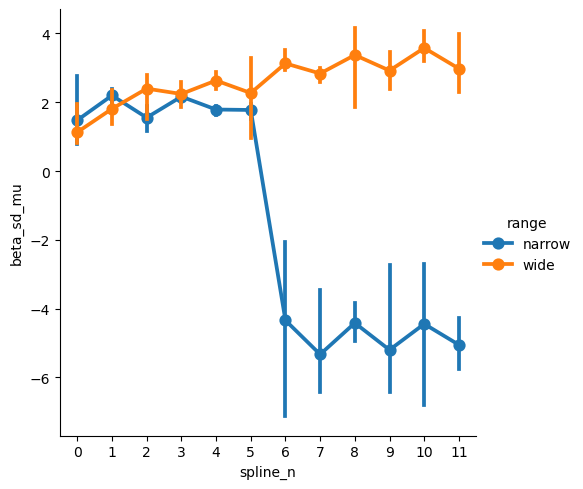

In [10]:
import arviz as az
import seaborn as sns
sns.catplot(x='spline_n', y='beta_sd_mu', hue='range', data=idata.posterior['beta_sd_mu'].to_dataframe(),
            kind='point',
            errorbar=lambda x: az.hdi(x.values))

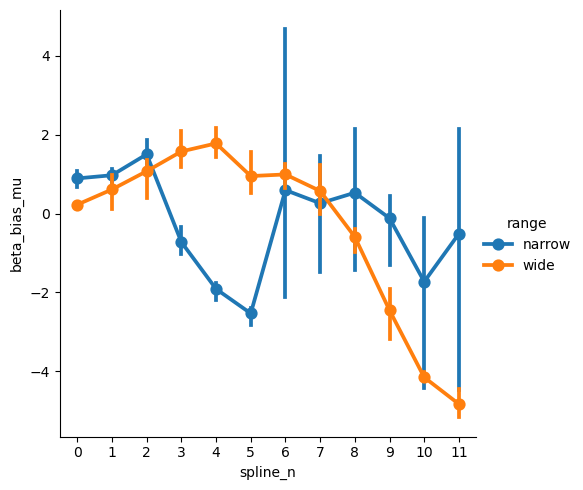

In [11]:
import arviz as az
import seaborn as sns
sns.catplot(x='spline_n', y='beta_bias_mu', hue='range', data=idata.posterior['beta_bias_mu'].to_dataframe(),
            kind='point',
            errorbar=lambda x: az.hdi(x.values))